## Import packages

In [94]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
import ecco_v4_py as ecco
warnings.filterwarnings('ignore')

import warnings
import cmocean
from dask.distributed import Client

from xmitgcm import llcreader

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

## Add the original grid

In [95]:
# define basin we want - here 6 is for Barents
# we can look directly at the layers output if we want to:
#  cd /scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

(50,) (50, 1350, 270)
hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [132]:
mskfaces = get_aste_faces(mskBasin,nfx,nfy)

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)


In [130]:
test = np.full((ny,nx),np.nan)
test[nfx[3]:nfy[0],0:nx] = mskBasin[nfx[3]:nfy[0],0:nx]

test2 = np.full((ny,nx),np.nan)
test2[nfy[0]:nfy[0]+nfy[2],0:nx]  = mskBasin[nfy[0]:nfy[0]+nfy[2],0:nx]

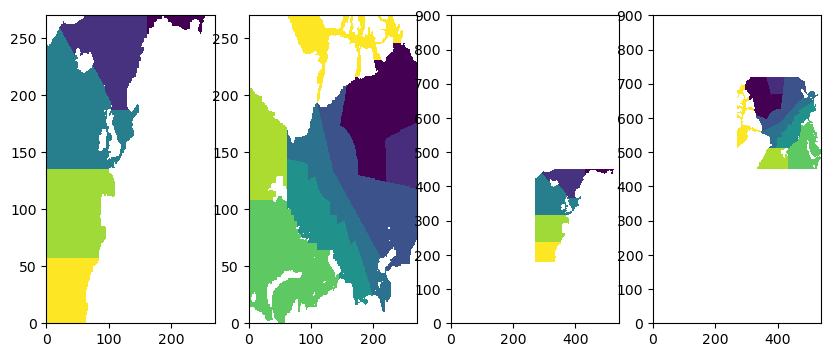

In [131]:
fig = plt.figure()

ax = plt.subplot(141)
ax.pcolormesh(mskfaces.f1[0][-270:])

ax = plt.subplot(142)
ax.pcolormesh(mskfaces.f3[0])

ax = plt.subplot(143)
ax.pcolormesh(get_aste_tracer(test,nfx,nfy)[0])

ax = plt.subplot(144)
ax.pcolormesh(get_aste_tracer(test2,nfx,nfy)[0])

In [80]:
# dyg
dyg3d.shape
dyg3d = get_aste_faces(dyg3d,nfx,nfy)
dyg3df1 = dyg3d.f1[:,-270:]
dyg3df3 = np.array([np.rot90(layer, 3) for layer in dyg3d.f3])
dyg3d = np.concatenate((dyg3df1, dyg3df3), axis=1)

# dxg
dxg3d.shape
dxg3d = get_aste_faces(dxg3d,nfx,nfy)
dxg3df1 = dxg3d.f1[:,-270:]
dxg3df3 = np.array([np.rot90(layer, 3) for layer in dxg3d.f3])
dxg3d = np.concatenate((dxg3df1, dxg3df3), axis=1)

nx 270
sz [  50 1350  270]
(50, 1350, 270)
tmp (50, 450, 270)
nx 270
sz [  50 1350  270]
(50, 1350, 270)
tmp (50, 450, 270)


In [81]:
drf3d = get_aste_faces(drf3d,nfx,nfy)
drf3df1 = drf3d.f1[:,-270:]
drf3df3 = np.array([np.rot90(layer, 3) for layer in drf3d.f3])
drf3d = np.concatenate((drf3df1, drf3df3), axis=1)

nx 270
sz [  50 1350  270]
(50, 1350, 270)
tmp (50, 450, 270)


In [82]:
RACfaces = get_aste_faces(mygrid['RAC'],nfx,nfy)     # this is of the
RACf1 = RACfaces.f1[0][-270:]
RACf3 = np.rot90(RACfaces.f3[0],3)
RAC2 = np.concatenate((RACf1, RACf3), axis=0)

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)


In [83]:
depthfaces = get_aste_faces(mygrid['Depth'],nfx,nfy)
depthf1 = depthfaces.f1[0][-270:]
depthf3 = np.rot90(depthfaces.f3[0],3)
DD2 = np.concatenate((depthf1, depthf3), axis=0)

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)


In [84]:
# make hfC into faces
hfCfaces = get_aste_faces(hfC,nfx,nfy)
hfCf1 = hfCfaces.f1[:,-270:]
hfCf3 = np.array([np.rot90(layer, 3) for layer in hfCfaces.f3])
hfC2 = np.concatenate((hfCf1, hfCf3), axis=1)

nx 270
sz [  50 1350  270]
(50, 1350, 270)
tmp (50, 450, 270)


In [85]:
# remake our stacked versions of the other faces
DRF = mygrid["DRF"]                        # this is already of depth 50

In [86]:
RAC3 = np.tile(RAC2,(nz,1,1))

## Load the dataset

In [87]:
aste = llcreader.CRIOSPortalASTE270Model()

In [88]:
ds = aste.get_dataset()
ds = ds.sel(time=slice('2014-12', '2015-01'))

In [89]:
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [90]:
ncols=10
for i,f in enumerate(list(ds.data_vars),start=1):
    end = '\n' if i%ncols==0 else ', '
    print(f,end=end)

ADVr_SLT, ADVr_TH, ADVxHEFF, ADVxSNOW, ADVx_SLT, ADVx_TH, ADVyHEFF, ADVySNOW, ADVy_SLT, ADVy_TH
DETADT2, DFrE_SLT, DFrE_TH, DFrI_SLT, DFrI_TH, DFxEHEFF, DFxESNOW, DFxE_SLT, DFxE_TH, DFyEHEFF
DFyESNOW, DFyE_SLT, DFyE_TH, ETAN, ETANSQ, GM_PsiX, GM_PsiY, KPPg_SLT, KPPg_TH, MXLDEPTH
PHIBOT, SALT, SFLUX, SIaaflux, SIacSubl, SIarea, SIatmFW, SIatmQnt, SIheff, SIhsnow
SIsnPrcp, SItflux, SIuice, SIvice, SRELAX, TFLUX, THETA, TRELAX, UVELMASS, VVELMASS
WSLTMASS, WTHMASS, WVELMASS, oceFWflx, oceQnet, oceQsw, oceSPDep, oceSPflx, oceSPtnd, oceSflux
oceTAUX, oceTAUY, sIceLoad, 

In [91]:
# select only the two tiles that we want
ds = ds.isel(tile=[1, 2])
ds

<xarray.Dataset>
Dimensions:   (tile: 2, i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_u: 50,
               k_l: 50, k_p1: 51, time: 2)
Coordinates:
  * tile      (tile) int64 1 2
  * i         (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 2014-12-01 2015-01-01
Data variables: (12/63)
    ADVr_SLT  (time, k_l, tile, j, i) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ADVr_TH   (time, k_l, tile, j, i) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ADVxHEFF  (time, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    ADVxSNOW  (time, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    ADVx_SLT  (time, k, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ADVx_TH   (time, k, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ...        ...
    oceSPflx  (time, tile, j, i) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    oceSPtnd  (time, k, tile, j, i) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    oceSflux  (time, tile, j, i) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    oceTAUX   (time, tile, j, i_g) float32 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    oceTAUY   (time, tile, j_g, i) float32 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    sIceLoad  (time, tile, j, i) float32 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>

## Add the budgeting items

All data we work with will need to be the stacked versions of the tiles 1 and 2
Look at the test_faces notebookt to see how to concatenate these arrays

In [92]:
dt = 2678400.0  # change later

In [93]:
ETANf1 = ds.ETAN.values[:,0,:,:]  # time
ETANf2 = np.array([np.rot90(layer, 3) for layer in ds.ETAN.values[:,1,:,:]])
ETAN = np.concatenate((ETANf1, ETANf2), axis=1)    # time, j, i
dETANdt = (ETAN[1]-ETAN[0])/dt

oceFWflx1 = ds.oceFWflx.values[:,0,:,:]  # time
oceFWflx2 = np.array([np.rot90(layer, 3) for layer in ds.oceFWflx.values[:,1,:,:]])
oceFWflx = np.concatenate((oceFWflx1, oceFWflx2), axis=1)   # time, j, i

In [40]:
# do mass convergence
if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
    tmp1 = mk3D_mod(mygrid['DRF'],hfC2) * hfC2
    tmp2 = tmp1/mk3D_mod(DD2,tmp1)

tmptend2 = tmp2 * mk3D_mod(dETANdt, tmp2) * myparms['rhoconst'] * mk3D_mod(RAC2, hfC2)    # kg/s

In [42]:
hfC2.shape

(50, 540, 270)

In [41]:
WVELMASSf1 = ds.WVELMASS.values[1,:,0,:,:]  # time
WVELMASSf3 = np.array([np.rot90(layer, 3) for layer in ds.WVELMASS.values[1,:,1,:,:]])
# WVELMASS = np.concatenate((oceFWflx1, oceFWflx2), axis=1)   # time, j, i


In [43]:
WVELMASSf3.shape

(50, 270, 270)

In [44]:
WVELMASS = np.concatenate((WVELMASSf1, WVELMASSf3), axis=1)   # time, j, i

In [45]:
oceFWflx.shape

(2, 540, 270)

In [46]:
# calculate zconv
# Perform calculations for zconv
budgO_zconv = oceFWflx[1]
print(budgO_zconv.shape)

if not myparms["useRFWF"]:
    budgO_zconv = 0 * budgO_zconv

trWtop = -WVELMASS * myparms["rhoconst"]
print(trWtop.shape)

# indexing seems fishy here - rewrite
if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO_fluxes_trWtop = trWtop * RAC3
budgO_fluxes_trWbot = trWbot * RAC3
budgO_fluxes_zconv = budgO_fluxes_trWtop - budgO_fluxes_trWbot

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO_zconv += np.sum(trWtop - trWbot, axis=0)

budgO_zconv = RAC2 * budgO_zconv
# ds["budgO_fluxes_zconv_mass"] = xr.DataArray(data = budgO_fluxes_zconv, dims = dims3d_avg,coords = coords3d_avg)

(540, 270)
(50, 540, 270)


In [47]:
ds = aste.get_dataset()

In [48]:
ds = ds.sel(time='2014-12')

In [49]:
# add hconv
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
grid = ecco.get_llc_grid(cds,domain='aste')
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'],
                                                ds['VVELMASS'],
                                                coords=cds,
                                                grid=grid)

In [50]:
tile1v = vvel.where(vvel.tile == 1, drop=True)[0,:,0,:,:]
tile2v = vvel.where(vvel.tile == 2, drop=True)[0,:,0,:,:]
tile2v = np.array([np.rot90(layer, 3) for layer in tile2v.values])
vvel = np.concatenate((tile1v, tile2v), axis=1)

In [51]:
tile1u = uvel.where(uvel.tile == 1, drop=True)[0,:,0,:,:]
tile2u = uvel.where(uvel.tile == 2, drop=True)[0,:,0,:,:]
tile2u = np.array([np.rot90(layer, 3) for layer in tile2u.values])
uvel = np.concatenate((tile1u, tile2u), axis=1)

In [52]:
print(uvel.shape,vvel.shape,dyg3d.shape,drf3d.shape,dxg3d.shape)

(50, 540, 270) (50, 540, 270) (50, 540, 270) (50, 540, 270) (50, 540, 270)


In [53]:
# calculate the hconvergence
# horizontal convergence
# Calculations for ocean
tmpUo = myparms['rhoconst'] * dyg3d * drf3d * uvel   # kg/s
tmpVo = myparms['rhoconst'] * dxg3d * drf3d * vvel   # kg/s
# tmpUo_tracer = get_aste_tracer(tmpUo,nfx,nfy)
# tmpVo_tracer = get_aste_tracer(tmpVo,nfx,nfy)

budgO_fluxes_hconv = calc_UV_conv_1face(tmpUo, tmpVo)
print(budgO_fluxes_hconv.shape)

(50, 540, 270)


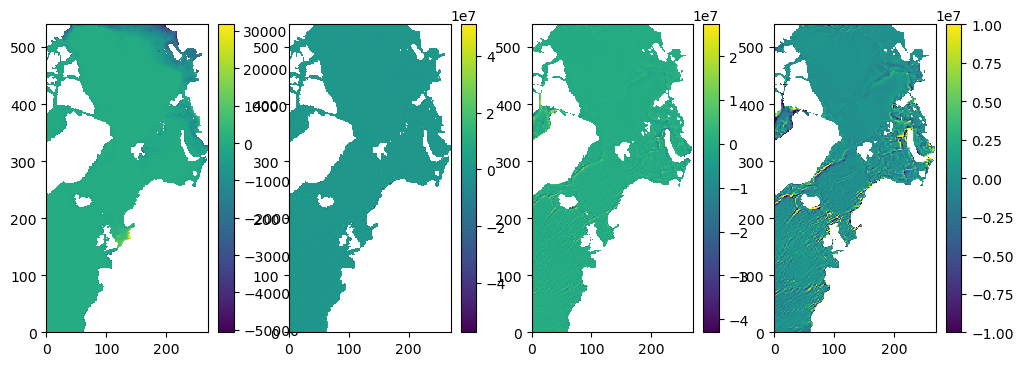

In [54]:
# test for tendency and horizontal convergence
plt.figure(figsize=(12,4))

ax = plt.subplot(141)
cb = ax.pcolormesh(tmptend2[0])
plt.colorbar(cb)

ax = plt.subplot(142)
cb = ax.pcolormesh(budgO_fluxes_zconv[0])
plt.colorbar(cb)

ax = plt.subplot(143)
cb = ax.pcolormesh(budgO_fluxes_hconv[0])
plt.colorbar(cb)

ax = plt.subplot(144)
cb = ax.pcolormesh(tmptend2[0]-budgO_fluxes_zconv[0]-budgO_fluxes_hconv[0],vmin=-10000000,vmax=10000000)
plt.colorbar(cb)

In [ ]:
# check for internal convergence

pt = np.array([[165,442,4],
               [210,300,10]])

In [ ]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 3):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = tmptend2[:, iy, ix] - budgO_fluxes_zconv[:, iy, ix] - budgO_fluxes_hconv[:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Mass")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO_fluxes_zconv[:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()

In [57]:
# maybe we do this whole routine with one face to see if closed?
ds = aste.get_dataset()
ds = ds.sel(time=slice('2014-12', '2015-01'))
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

ncols=10
for i,f in enumerate(list(ds.data_vars),start=1):
    end = '\n' if i%ncols==0 else ', '
    print(f,end=end)

# select only the two tiles that we want
ds = ds.isel(tile=[1])
ds

ADVr_SLT, ADVr_TH, ADVxHEFF, ADVxSNOW, ADVx_SLT, ADVx_TH, ADVyHEFF, ADVySNOW, ADVy_SLT, ADVy_TH
DETADT2, DFrE_SLT, DFrE_TH, DFrI_SLT, DFrI_TH, DFxEHEFF, DFxESNOW, DFxE_SLT, DFxE_TH, DFyEHEFF
DFyESNOW, DFyE_SLT, DFyE_TH, ETAN, ETANSQ, GM_PsiX, GM_PsiY, KPPg_SLT, KPPg_TH, MXLDEPTH
PHIBOT, SALT, SFLUX, SIaaflux, SIacSubl, SIarea, SIatmFW, SIatmQnt, SIheff, SIhsnow
SIsnPrcp, SItflux, SIuice, SIvice, SRELAX, TFLUX, THETA, TRELAX, UVELMASS, VVELMASS
WSLTMASS, WTHMASS, WVELMASS, oceFWflx, oceQnet, oceQsw, oceSPDep, oceSPflx, oceSPtnd, oceSflux
oceTAUX, oceTAUY, sIceLoad, 

<xarray.Dataset>
Dimensions:   (tile: 1, i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_u: 50,
               k_l: 50, k_p1: 51, time: 2)
Coordinates:
  * tile      (tile) int64 1
  * i         (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 2014-12-01 2015-01-01
Data variables: (12/63)
    ADVr_SLT  (time, k_l, tile, j, i) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ADVr_TH   (time, k_l, tile, j, i) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ADVxHEFF  (time, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    ADVxSNOW  (time, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    ADVx_SLT  (time, k, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ADVx_TH   (time, k, tile, j, i_g) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    ...        ...
    oceSPflx  (time, tile, j, i) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    oceSPtnd  (time, k, tile, j, i) float64 dask.array<chunksize=(1, 1, 1, 270, 270), meta=np.ndarray>
    oceSflux  (time, tile, j, i) float64 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    oceTAUX   (time, tile, j, i_g) float32 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    oceTAUY   (time, tile, j_g, i) float32 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>
    sIceLoad  (time, tile, j, i) float32 dask.array<chunksize=(1, 1, 270, 270), meta=np.ndarray>

In [58]:
ETAN = ds.ETAN.values[:,0,:,:]
dETANdt = (ETAN[1]-ETAN[0])/dt

In [59]:
oceFWflx = ds.oceFWflx.values[1,0,:,:]

In [67]:
WVELMASS.shape

(50, 540, 270)

In [65]:
# do mass convergence
if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
    tmp1 = mk3D_mod(mygrid['DRF'],hfC2[:,:270]) * hfC2[:,:270]
    print(tmp1.shape)
    tmp2 = tmp1/mk3D_mod(DD2[:270,:],tmp1)

print(RAC2.shape)

tmptend2 = tmp2 * mk3D_mod(dETANdt, tmp2) * myparms['rhoconst'] * mk3D_mod(RAC2[:270,:], hfC2[:,:270])    # kg/s

(50, 270, 270)
(540, 270)


In [70]:
# calculate zconv
# Perform calculations for zconv
budgO_zconv = oceFWflx
print(budgO_zconv.shape)

if not myparms["useRFWF"]:
    budgO_zconv = 0 * budgO_zconv

trWtop = -WVELMASS[:,:270] * myparms["rhoconst"]
print(trWtop.shape)

# indexing seems fishy here - rewrite
if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:270, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO_fluxes_trWtop = trWtop * RAC3[:,:270]
budgO_fluxes_trWbot = trWbot * RAC3[:,:270]
budgO_fluxes_zconv = budgO_fluxes_trWtop - budgO_fluxes_trWbot

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO_zconv += np.sum(trWtop - trWbot, axis=0)

budgO_zconv = RAC2[:270,:] * budgO_zconv
# ds["budgO_fluxes_zconv_mass"] = xr.DataArray(data = budgO_fluxes_zconv, dims = dims3d_avg,coords = coords3d_avg)

(270, 270)
(50, 270, 270)


In [71]:
# add hconv
ds = aste.get_dataset()
ds = ds.sel(time='2014-12')
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
grid = ecco.get_llc_grid(cds,domain='aste')
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'],
                                                ds['VVELMASS'],
                                                coords=cds,
                                                grid=grid)

In [74]:
# calculate the hconvergence
# horizontal convergence
# Calculations for ocean
tmpUo = myparms['rhoconst'] * dyg3d[:,:270] * drf3d[:,:270] * uvel.values[0,:,1,:,:]   # kg/s
tmpVo = myparms['rhoconst'] * dxg3d[:,:270] * drf3d[:,:270] * vvel.values[0,:,1,:,:]   # kg/s

budgO_fluxes_hconv = calc_UV_conv_1face(tmpUo, tmpVo)
print(budgO_fluxes_hconv.shape)

(50, 270, 270)


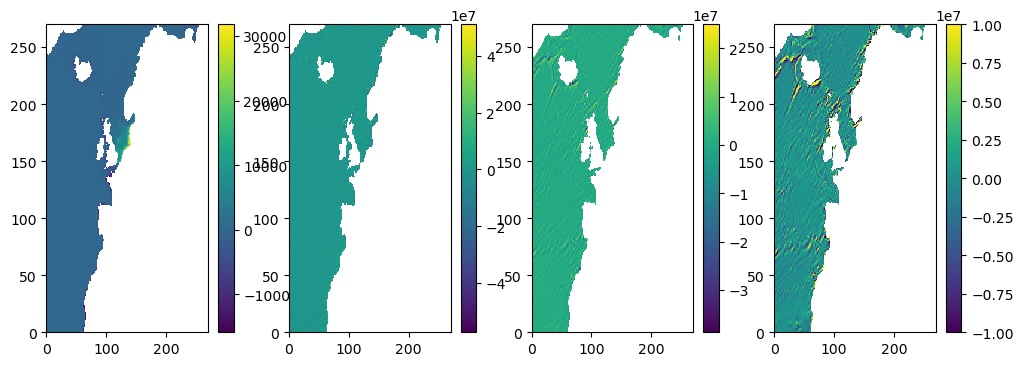

In [75]:
# test for tendency and horizontal convergence
plt.figure(figsize=(12,4))

ax = plt.subplot(141)
cb = ax.pcolormesh(tmptend2[0])
plt.colorbar(cb)

ax = plt.subplot(142)
cb = ax.pcolormesh(budgO_fluxes_zconv[0])
plt.colorbar(cb)

ax = plt.subplot(143)
cb = ax.pcolormesh(budgO_fluxes_hconv[0])
plt.colorbar(cb)

ax = plt.subplot(144)
cb = ax.pcolormesh(tmptend2[0]-budgO_fluxes_zconv[0]-budgO_fluxes_hconv[0],vmin=-10000000,vmax=10000000)
plt.colorbar(cb)

In [76]:
# check for internal convergence

pt = np.array([[100,250,4],
               [50,150,10]])

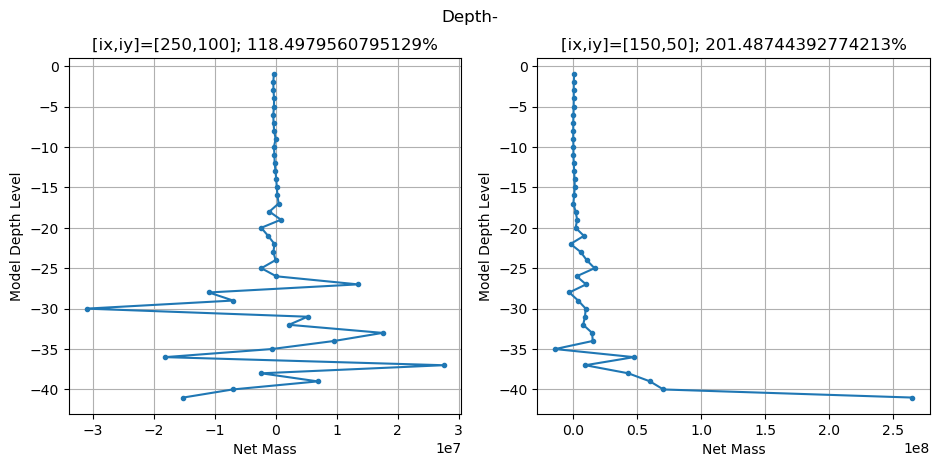

In [77]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 3):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = tmptend2[:, iy, ix] - budgO_fluxes_zconv[:, iy, ix] - budgO_fluxes_hconv[:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Mass")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO_fluxes_zconv[:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()